In [1]:
import warnings
warnings.filterwarnings("ignore")

In [52]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px


#for modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

#for evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
raw_df = pd.read_csv('/kaggle/input/google-stock-2024/Google.csv')

In [4]:
print('nomber of samples :',raw_df.shape[0])
print('nomber of columns :',raw_df.shape[1])
raw_df.head(11)

nomber of samples : 2113
nomber of columns : 8


,Unnamed: 0,open,high,low,close,adjclose,volume,ticker
0,2016-01-04,37.150002,37.202999,36.562901,37.091999,37.091999,65456000,GOOG
1,2016-01-05,37.322498,37.599998,36.931999,37.129002,37.129002,39014000,GOOG
2,2016-01-06,36.500000,37.359001,36.445999,37.181000,37.181000,38940000,GOOG
3,2016-01-07,36.515499,36.924999,35.952999,36.319500,36.319500,59274000,GOOG
4,2016-01-08,36.572498,36.661499,35.650002,35.723499,35.723499,49018000,GOOG
5,2016-01-11,35.830502,35.942749,35.176998,35.801498,35.801498,41812000,GOOG
6,2016-01-12,36.084000,36.437500,35.865849,36.303501,36.303501,40490000,GOOG
7,2016-01-13,36.542500,36.737000,34.930500,35.028000,35.028000,50034000,GOOG
8,2016-01-14,35.269001,36.096249,34.455002,35.736000,35.736000,44516000,GOOG
9,2016-01-15,34.614498,35.337002,34.268501,34.722500,34.722500,72162000,GOOG


first columns is unnamed so ve have tio change it

In [5]:
raw_df.rename( columns={raw_df.columns[0] : 'date'}, inplace=True)

In [6]:
raw_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2113 entries, 0 to 2112
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      2113 non-null   object 
 1   open      2113 non-null   float64
 2   high      2113 non-null   float64
 3   low       2113 non-null   float64
 4   close     2113 non-null   float64
 5   adjclose  2113 non-null   float64
 6   volume    2113 non-null   int64  
 7   ticker    2113 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 132.2+ KB


In [7]:
raw_df.describe()


,open,high,low,close,adjclose,volume
count,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2.113000e+03
mean,82.510420,83.408536,81.696887,82.576327,82.576327,3.040611e+07
std,37.784157,38.224165,37.394997,37.818402,37.818402,1.406362e+07
min,33.392502,33.615002,33.153000,33.412998,33.412998,6.936000e+06
25%,52.043999,52.634998,51.264000,51.973000,51.973000,2.147350e+07
50%,68.087502,68.879997,67.449997,68.058502,68.058502,2.663600e+07
75%,116.760002,118.349998,115.337502,117.010498,117.010498,3.451000e+07
max,178.779999,179.949997,177.309998,179.539993,179.539993,1.269620e+08


checking for null

In [8]:
print('Null Values:',raw_df.isnull().values.sum(),)

Null Values: 0


## eda

In [9]:
print('starting date : ', raw_df.iloc[0][0])
print('last date : ', raw_df.iloc[-1][0])

starting date :  2016-01-04
last date :  2024-05-24


In [10]:
raw_df['date'] = pd.to_datetime(raw_df['date'], format='%Y-%m-%d')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2113 entries, 0 to 2112
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2113 non-null   datetime64[ns]
 1   open      2113 non-null   float64       
 2   high      2113 non-null   float64       
 3   low       2113 non-null   float64       
 4   close     2113 non-null   float64       
 5   adjclose  2113 non-null   float64       
 6   volume    2113 non-null   int64         
 7   ticker    2113 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 132.2+ KB


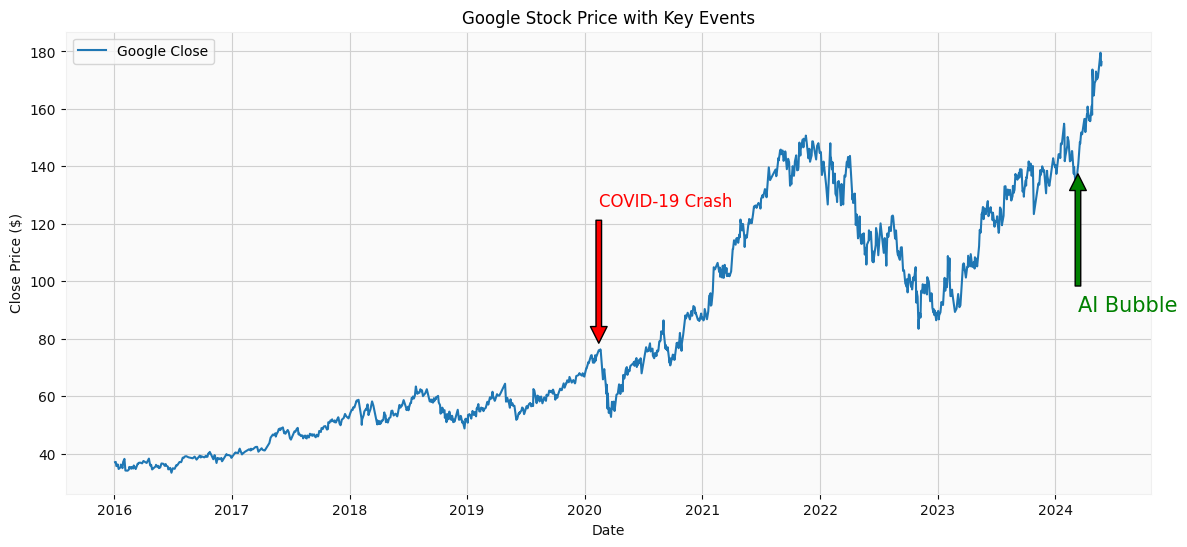

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(14,6))
plt.plot(raw_df['date'], raw_df['close'], label='Google Close')


covid_price, covid_date = get_nearest_price(raw_df, '2020-02-16')
plt.annotate('COVID-19 Crash',
             xy=(covid_date, covid_price),
             xytext=(covid_date, covid_price + 50),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=12,
             color='red')

ai_price, ai_date = get_nearest_price(raw_df, '2024-03-12')
plt.annotate('AI Bubble',
             xy=(ai_date, ai_price),
             xytext=(ai_date, ai_price - 50),
             arrowprops=dict(facecolor='green', shrink=0.05),
             fontsize=15,
             color='green')

plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.title('Google Stock Price with Key Events')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
pip install --upgrade mplfinance

Note: you may need to restart the kernel to use updated packages.


In [13]:
import mplfinance as mpf

In [24]:
p_df = raw_df.copy(deep=True)
p_df['date'] = pd.to_datetime(p_df['date'])
p_df.set_index('date', inplace=True)
p_df['year'] = p_df.index.year

<Figure size 640x480 with 0 Axes>

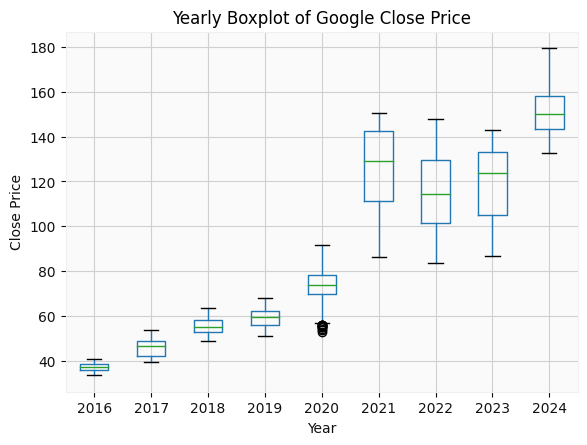

In [30]:
plt.figure()
p_df.boxplot(column='close', by='year')
plt.title('Yearly Boxplot of Google Close Price')
plt.suptitle('')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.show()


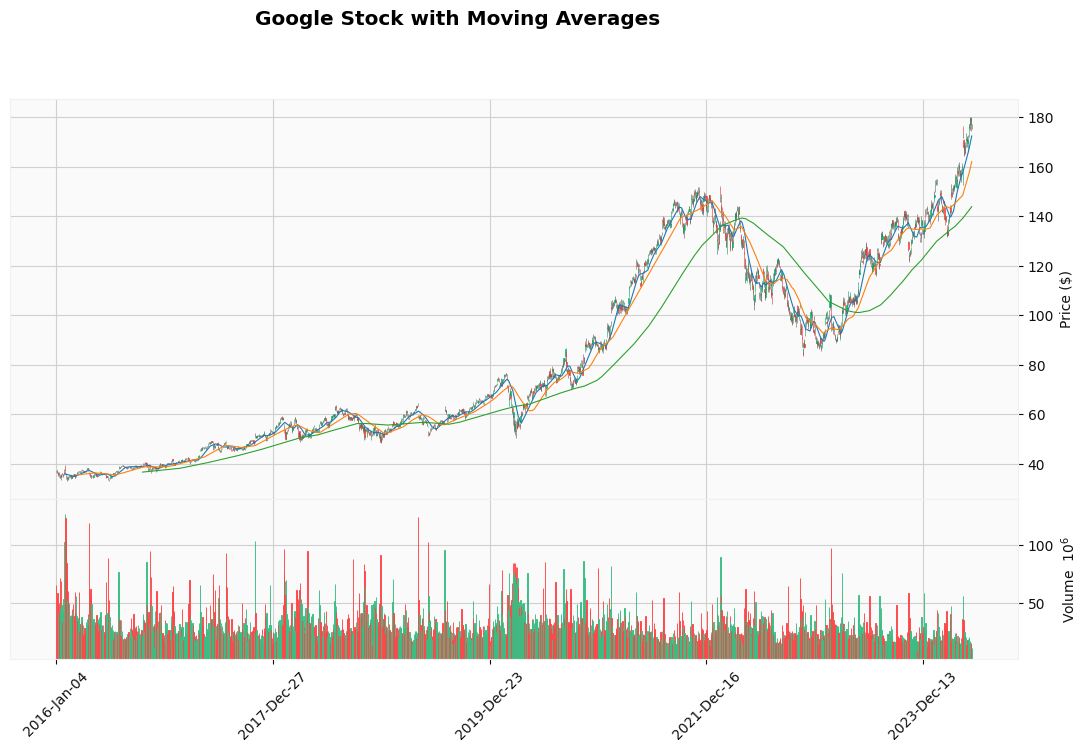

In [34]:
mpf.plot(p_df,
         type='candle',
         mav=(20,50,200),
         style='yahoo',
         title='Google Stock with Moving Averages',
         ylabel='Price ($)',
         volume=True,
        figsize=(14, 8))

In [59]:
import plotly.express as px

fig = px.line(
    raw_df,
    x='date',
    y=['open', 'close', 'high', 'low'],  # ← فقط اسم ستون‌ها
    labels={'value':'Stock Price ($)', 'variable':'Stock Parameter'},
    title='Google Stock Analysis'
)

# تنظیمات بصری
fig.update_layout(
    font_size=14,
    font_color='black',
    legend_title_text='Stock Parameters',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False)
)

fig.show()


# LSTM Model